# Курсовой проект по курсу Фреймворк PyTorch 

In [1]:
import numpy as np 
import os 
from PIL import Image ,ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd


import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader


import time
from torch.autograd import Variable

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device= get_default_device()   

In [3]:
path='D:\\Dataset\\leapGestRecog'

Получим словарь labels по структуре каталогов датасета

In [4]:
labels = dict()
revers = dict()
count = 0
for i, dir_name in enumerate (os.listdir(path+'\\00\\')):
    labels[dir_name]=i
    revers[i]=dir_name
labels

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [5]:
x_data = []
y_data = []
for i in range(0,10):
     for j in os.listdir(path+'\\0' + str(i) + '\\'):
            for k in os.listdir(path+'\\0' + str(i) + '\\'+j):
                path_file=path+'\\0' + str(i) + '\\'+j+'\\'+k
                x_data.append(path_file)
                y_data.append(labels[j])
             

In [9]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test,y_train, y_test = train_test_split(x_data,y_data,test_size=0.3)
 

In [10]:
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor()])

In [11]:
    
class CustomDatasetFromImages(Dataset):
    def __init__(self, preprocess,image_arr,label_arr):
        self.image_arr = image_arr
        self.label_arr = label_arr
        self.preprocess=preprocess
        
    
        self.data_len = len(image_arr)
    def __getitem__(self, index):
  
        img = Image.open(self.image_arr[index])
        img=self.preprocess(img)
          
        return (img,self.label_arr[index])

    def __len__(self):
        return self.data_len

In [12]:
train_data = CustomDatasetFromImages(preprocess,X_train,y_train)
test_data = CustomDatasetFromImages(preprocess,X_test,y_test)

In [13]:
for data in train_data:
    print(data)
    break
    

(tensor([[[0.0314, 0.0353, 0.0392,  ..., 0.0235, 0.0275, 0.0275],
         [0.0314, 0.0314, 0.0353,  ..., 0.0235, 0.0275, 0.0275],
         [0.0275, 0.0275, 0.0314,  ..., 0.0275, 0.0275, 0.0275],
         ...,
         [0.0510, 0.0510, 0.0549,  ..., 0.0627, 0.0627, 0.0667],
         [0.0510, 0.0549, 0.0549,  ..., 0.0627, 0.0588, 0.0627],
         [0.0510, 0.0588, 0.0549,  ..., 0.0627, 0.0588, 0.0627]]]), 5)


In [14]:
batch_size=5
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

torch.Size([5, 1, 128, 128])


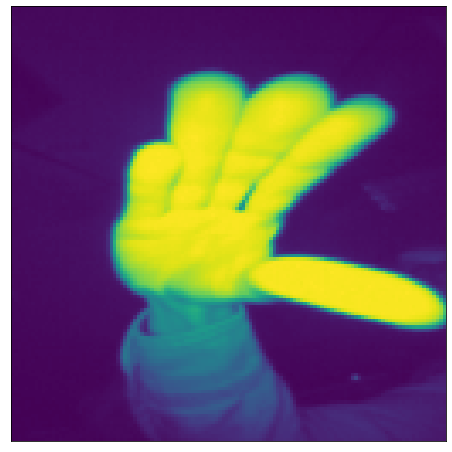

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        print(images.shape)
        ax.imshow(images[0][0])
        break
show_batch(train_dataloader)


In [16]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(8), 
                                        nn.Flatten(),
                                        nn.Linear(2048, 10))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        out = self.classifier(out)
        return out

In [17]:
model = Net(1, len(y_train))

In [18]:
model=model.to(device)

In [20]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
epochs = 20
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [21]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 2800 total_steps per epoch


In [23]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [35]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        
        epoch_loss.append(loss.item())
       
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  0.6509832144165716
Epoch 2, loss:  0.6072160342667413
Epoch 3, loss:  0.33677623709725235
Epoch 4, loss:  0.1982120635709408
Epoch 5, loss:  0.19192979524802595
Epoch 6, loss:  0.21461833159745766
Epoch 7, loss:  0.16607782766327106
Epoch 8, loss:  0.17372343135365745
Epoch 9, loss:  0.11674489864000634
Epoch 10, loss:  0.12265043863211697
Epoch 11, loss:  0.07735578027122171
Epoch 12, loss:  0.08855956906848013
Epoch 13, loss:  0.027645361582859934
Epoch 14, loss:  0.02325691150870023
Epoch 15, loss:  0.01427348617300464


KeyboardInterrupt: 

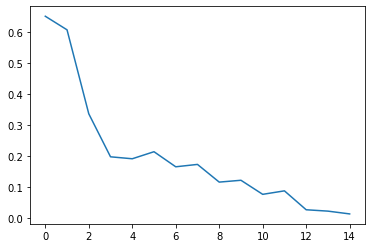

In [25]:
plt.plot(epoch_losses)

сохранение модели

In [39]:
torch.save(model.state_dict(), '15_epoch.pth')

Загрузка сохраненой модели

In [26]:
net=Net(1, len(labels)).to(device)
net.load_state_dict(torch.load('35_epoch.pth',map_location=device))
net.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

torch.Size([5, 1, 128, 128])


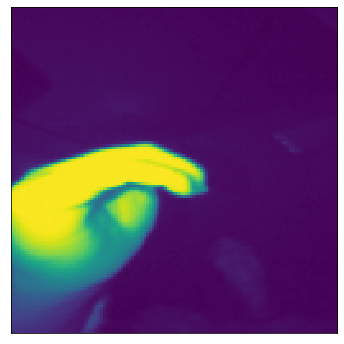

In [27]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        print(images.shape)
        ax.imshow(images[0][0])
        break
show_batch(test_dataloader)

проверка на тестовых данных

e:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


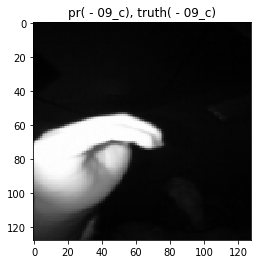

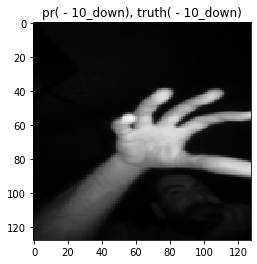

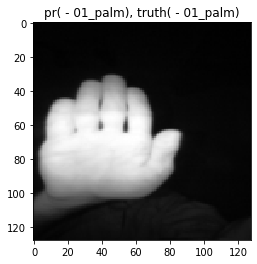

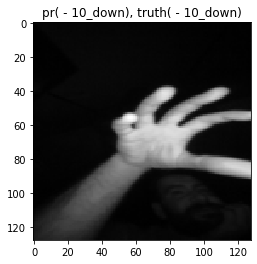

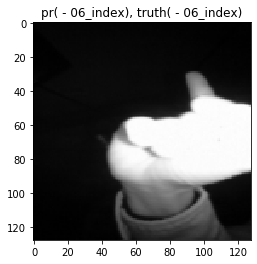

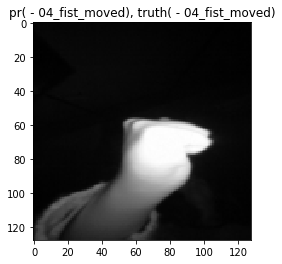

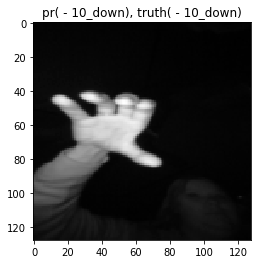

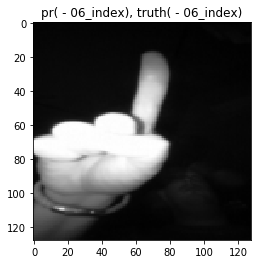

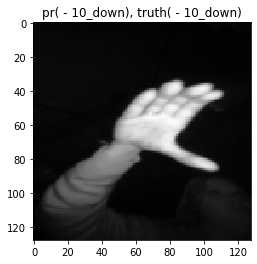

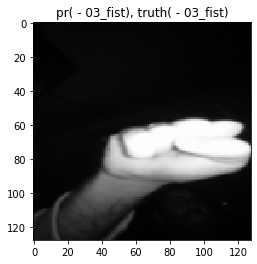

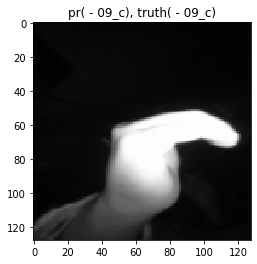

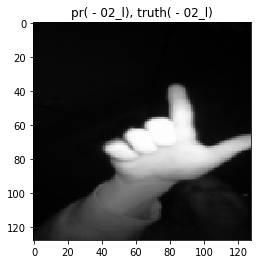

In [28]:
with torch.no_grad():
    for i, (images,label) in enumerate(test_dataloader):
        images, label = Variable(images,volatile=True), Variable(label,volatile=True)
        outputs = net(images)
        plt.title(f'pr( - {revers[outputs[0].argmax().item()]}), truth( - {revers[label[0].item()]})')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [24]:
#pip install opencv-python

#### обработка изображения с вебкамеры

In [29]:
import cv2
import torch
import numpy as np

In [31]:
prepear = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize(128),
        transforms.ToTensor() ,
        transforms.Normalize(0.5, 0.5),])

In [61]:
images=[]
dt=0

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    frame=cv2.rotate(frame,cv2.ROTATE_180)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    im=prepear(image)
    im=im.unsqueeze(0)
    outputs = net(im)
    answer=outputs[0].argmax().item()
   
    if dt!=answer:
        text=revers[answer]
        cv2.putText(frame, text,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        images.append(frame)
    cv2.imshow('geasture detection', frame)
    dt=answer
    if cv2.waitKey(1) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()


In [38]:
cap.release()
cv2.destroyAllWindows()

# Результат

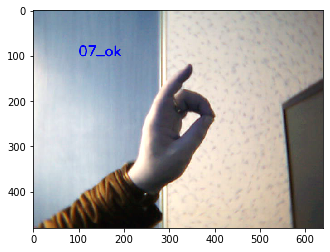

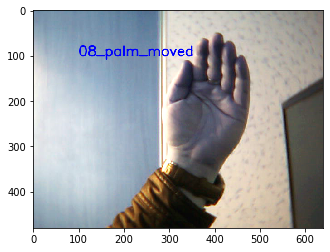

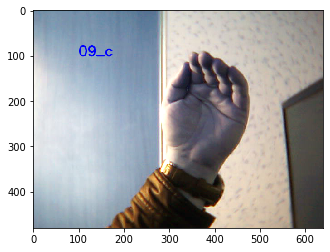

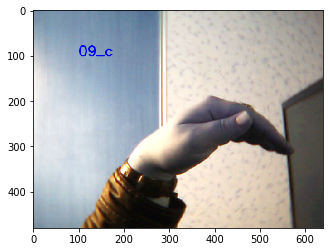

In [64]:
for i in [12,15,16,24]:
    plt.imshow(images[i])
    plt.show()